In [3]:
!pip3 install xgboost

     |████████████████████████████████| 1.2 MB 1.9 MB/s eta 0:00:01


In [8]:
!pip3 install torch

     |████████████████████████████████| 127.9 MB 11.5 MB/s eta 0:00:01    |██████▉                         | 27.4 MB 15.0 MB/s eta 0:00:07     |███████████████████████████████ | 124.0 MB 11.5 MB/s eta 0:00:01


In [9]:
import copy
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# rc('font', family=font_name)    
# matplotlib.rcParams['axes.unicode_minus'] = False      
# pd.set_option('display.float_format', '{:.2f}'.format)
# pd.set_option('display.max_columns', 150)

from xgboost import XGBRegressor

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False)
random_seed = 616

In [10]:
y_col = '유입량'
PK_col = ['홍수사상번호','연','월','일','시간']

In [12]:
data_raw = pd.read_excel('/Users/andrew/hongsu/data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data_raw = data_raw.dropna()

data_raw.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data_raw.columns.values]

In [38]:
# 결과 값 저장할 dataframe 생성

predict_df = pd.DataFrame()
predict_df[PK_col] = data_raw[PK_col]
predict_df['true'] = data_raw.유입량

score_df = pd.DataFrame()

In [14]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [15]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [16]:
first_values = data_raw.groupby('홍수사상번호').first()['유입량']

def dnn_predict(name, data, model_structure, scaler, view=False, view_num=5, early_stop_num = 3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device
    pred_values = []
    predict_df = pd.DataFrame()
    predict_df[PK_col] = data[['홍수사상번호','연','월','일','시간']]
    predict_df['true'] = data.유입량
    
    for num in data.홍수사상번호.unique():
        print(f"홍수사상번호 {num} 시작")
        train = data[data['홍수사상번호'] != num].dropna().copy()
        valid = data[data['홍수사상번호'] == num].copy()

        X_train = train.drop(columns=[y_col]+PK_col)
        y_train = train[y_col]

        X_valid = valid.drop(columns=[y_col]+PK_col)
        y_valid = valid[y_col]
        
        scaler.fit(X_train)

        X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
        X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

        y_train_tensors = torch.Tensor(y_train.values).to(device)
        y_valid_tensors = torch.Tensor(y_valid.values).to(device)
        
        input_size = X_train.shape[1]

        dnn = DNN(input_size, model_structure["hidden_layer"], model_structure["batch_norm"],
                  model_structure["drop_out"], model_structure["drop_prob"]).to(device)
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(dnn.parameters(), lr=model_structure["learning_rate"])  # adam optimizer
        
        best_loss = 1E+10
        best_epoch = 0
        for epoch in range(model_structure["num_epochs"]):
            optimizer.zero_grad()
            outputs = dnn(X_train_tensors)
            loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                dnn.eval()
                outputs_valid = dnn(X_valid_tensors)
                loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
                if loss_valid < best_loss:
                    best_loss = loss_valid
                    best_epoch = epoch
                    pred_valid = list(outputs_valid.view(-1).detach().cpu().numpy())
                dnn.train()

            if view and ((epoch+1) % (model_structure["num_epochs"]//view_num) == 0):
                print("  Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))
            
            if (epoch - best_epoch) > (model_structure["num_epochs"] // early_stop_num):
                print("Best Epoch: %d Best Valid Loss: %1.2f" % (best_epoch+1, best_loss.item()))
                break
        print("")
        pred_values += pred_valid
    
    predict_df[f'pred_{name}'] = pred_values
    
    return predict_df

In [17]:
def plot_hongsunum(predict_df, names = None):
    if names == None :
        pred_names = ['true'] + list(predict_df.filter(regex='pred_').columns)
    else:
        pred_names = ['true'] + [f"pred_{name}" for name in names]
        
    for idx in predict_df['홍수사상번호'].unique():
        predict_df.loc[predict_df['홍수사상번호'] ==idx][pred_names].plot(figsize=(20,12))
        plt.legend()
        plt.title(f"홍수사상번호 : {idx}")
        plt.show()

In [18]:
def fill_nan(predict_df):
    for num in predict_df.홍수사상번호:
        predict_num = predict_df[predict_df.홍수사상번호 == num]
        predict_num = predict_num.fillna(method='ffill').fillna(method='bfill')
        predict_df.loc[predict_df.홍수사상번호 == num] = predict_num
        
def rmse(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_error(true, pred))

def rmsle(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_log_error(true, pred))
    
def r2(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return r2_score(true, pred)

def mape(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.mean(np.abs((true - pred) / true))*100

In [39]:
model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

In [20]:
name = 'x2'
data_x2 = data_raw.copy()

x2_col = data_x2.filter(regex="수위\(D지역\)").columns
for col in x2_col:
    data_x2[col + '_x2'] = data_x2[col] ** 2


In [40]:
name = 'x2'
data_x2 = data_raw.copy()

x2_col = data_x2.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_x2[col + '_x2'] = data_x2[col] ** 2

In [41]:
data_x2.head() # 수위(E지역)

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1_유역평균강수,데이터집단 1_강우(A지역),데이터집단 1_강우(B지역),데이터집단 1_강우(C지역),...,데이터 집단 6_강우(C지역),데이터 집단 6_강우(D지역),데이터 집단 6_수위(E지역),데이터 집단 6_수위(D지역),데이터집단 1_수위(E지역)_x2,데이터집단 2_수위(E지역)_x2,데이터집단 3_수위(E지역)_x2,데이터 집단 4_수위(E지역)_x2,데이터 집단 5_수위(E지역)_x2,데이터 집단 6_수위(E지역)_x2
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,8,2.54,122.610,6.4516,6.4516,6.4516,6.4516,6.4516,6.4516
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,10,2.53,122.600,6.4009,6.4009,6.4009,6.4009,6.4009,6.4009
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,10,11,2.53,122.590,6.4009,6.4009,6.4009,6.4009,6.4009,6.4009
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,15,14,2.53,122.585,6.4009,6.4009,6.4009,6.4009,6.4009,6.4009
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,18,16,2.53,122.575,6.4009,6.4009,6.4009,6.4009,6.4009,6.4009


In [21]:
data_x2.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1_유역평균강수,데이터집단 1_강우(A지역),데이터집단 1_강우(B지역),데이터집단 1_강우(C지역),...,데이터 집단 6_강우(C지역),데이터 집단 6_강우(D지역),데이터 집단 6_수위(E지역),데이터 집단 6_수위(D지역),데이터집단 1_수위(D지역)_x2,데이터집단 2_수위(D지역)_x2,데이터집단 3_수위(D지역)_x2,데이터 집단 4_수위(D지역)_x2,데이터 집단 5_수위(D지역)_x2,데이터 집단 6_수위(D지역)_x2
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,8,2.54,122.610,15023.098477,15016.460078,15018.502500,15049.155625,15045.475600,15033.212100
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,10,2.53,122.600,15021.566406,15018.502500,15020.545061,15047.403166,15042.531904,15030.760000
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,10,11,2.53,122.590,15020.034414,15020.545061,15022.587786,15045.650833,15039.588496,15028.308100
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,15,14,2.53,122.585,15020.034414,15022.587786,15024.630625,15043.898577,15035.664400,15027.082225
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,18,16,2.53,122.575,15020.034414,15024.630625,15024.630625,15040.394397,15031.740816,15024.630625


In [42]:
predict_temp = dnn_predict(name, data_x2, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')

홍수사상번호 1 시작
Best Epoch: 1390 Best Valid Loss: 627239.06

홍수사상번호 2 시작
Best Epoch: 938 Best Valid Loss: 769282.00

홍수사상번호 3 시작
Best Epoch: 448 Best Valid Loss: 48051.62

홍수사상번호 4 시작
Best Epoch: 495 Best Valid Loss: 185820.97

홍수사상번호 5 시작
Best Epoch: 1111 Best Valid Loss: 1150199.62

홍수사상번호 6 시작
Best Epoch: 468 Best Valid Loss: 61001.33

홍수사상번호 7 시작
Best Epoch: 580 Best Valid Loss: 176196.83

홍수사상번호 8 시작
Best Epoch: 890 Best Valid Loss: 485488.62

홍수사상번호 9 시작
Best Epoch: 630 Best Valid Loss: 85995.20

홍수사상번호 10 시작
Best Epoch: 477 Best Valid Loss: 44977.00

홍수사상번호 11 시작
Best Epoch: 497 Best Valid Loss: 54230.72

홍수사상번호 12 시작
Best Epoch: 689 Best Valid Loss: 46640.06

홍수사상번호 13 시작
Best Epoch: 626 Best Valid Loss: 72477.03

홍수사상번호 14 시작
Best Epoch: 1688 Best Valid Loss: 187015.09

홍수사상번호 15 시작
Best Epoch: 648 Best Valid Loss: 48472.41

홍수사상번호 16 시작
Best Epoch: 485 Best Valid Loss: 30981.47

홍수사상번호 17 시작
Best Epoch: 807 Best Valid Loss: 198699.73

홍수사상번호 18 시작
Best Epoch: 495 Best Valid Loss:

In [43]:
predict_df

,홍수사상번호,연,월,일,시간,true,pred_x2
0,1,2006,7,10,8,189.100000,98.541039
1,1,2006,7,10,9,216.951962,109.612061
2,1,2006,7,10,10,251.424419,116.920944
3,1,2006,7,10,11,302.812199,147.341827
4,1,2006,7,10,12,384.783406,178.044708
...,...,...,...,...,...,...,...
2886,25,2017,7,18,18,513.368437,444.610413
2887,25,2017,7,18,19,502.846843,437.667664
2888,25,2017,7,18,20,491.954805,432.030975
2889,25,2017,7,18,21,481.103083,424.163666


In [44]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [45]:
score_df

,RMSE,RMSLE,R2_score,MAPE
x2,443.236728,0.440996,0.958715,25.03526


## log 변환

In [ ]:
for col in data_raw.filter(regex='데이터집단 1').columns:
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1, 2, 1)
    data_raw[col].hist(bins=50, ax=ax1)
    ax1.set_title(col)
    
    ax2 = fig.add_subplot(1, 2, 2)
    np.log(data_raw[col] - data_raw[col].min() + 0.001).hist(bins=50, ax=ax2, color='r')
    ax2.set_title(col + '_log')
    plt.show()


In [46]:
name = 'log'
data_log = data_raw.copy()

log_col = data_log.columns.difference(list(data_log.filter(regex="수위\(E지역\)").columns) + [y_col] + PK_col)
for col in log_col:
    data_log[col + '_zero'] = (data_log[col] == 0).astype(int)
    data_log[col] = data_log[col].apply(lambda x : np.log(x - data_log[col].min() + 0.01))

In [47]:
predict_temp = dnn_predict(name, data_log, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')


홍수사상번호 1 시작
Best Epoch: 1351 Best Valid Loss: 1499612.88

홍수사상번호 2 시작
Best Epoch: 624 Best Valid Loss: 941408.94

홍수사상번호 3 시작
Best Epoch: 317 Best Valid Loss: 84040.93

홍수사상번호 4 시작
Best Epoch: 410 Best Valid Loss: 110064.46

홍수사상번호 5 시작
Best Epoch: 1993 Best Valid Loss: 1579420.12

홍수사상번호 6 시작
Best Epoch: 338 Best Valid Loss: 62138.25

홍수사상번호 7 시작
Best Epoch: 970 Best Valid Loss: 175650.30

홍수사상번호 8 시작
Best Epoch: 1161 Best Valid Loss: 410445.41

홍수사상번호 9 시작
Best Epoch: 560 Best Valid Loss: 72246.23

홍수사상번호 10 시작
Best Epoch: 357 Best Valid Loss: 28287.89

홍수사상번호 11 시작
Best Epoch: 416 Best Valid Loss: 33228.07

홍수사상번호 12 시작
Best Epoch: 1797 Best Valid Loss: 78299.56

홍수사상번호 13 시작
Best Epoch: 475 Best Valid Loss: 103072.39

홍수사상번호 14 시작
Best Epoch: 1042 Best Valid Loss: 270923.50

홍수사상번호 15 시작
Best Epoch: 643 Best Valid Loss: 78072.91

홍수사상번호 16 시작
Best Epoch: 382 Best Valid Loss: 23222.48

홍수사상번호 17 시작
Best Epoch: 522 Best Valid Loss: 168932.34

홍수사상번호 18 시작
Best Epoch: 1014 Best Valid 

In [48]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [49]:
score_df

,RMSE,RMSLE,R2_score,MAPE
x2,443.236728,0.440996,0.958715,25.035260
log,539.023868,0.395914,0.938942,27.937532


In [50]:
name = 'origin + log'
data_originlog = data_raw.copy()

log_col = data_originlog.columns.difference(list(data_originlog.filter(regex="수위\(E지역\)").columns) + [y_col] + PK_col)
for col in log_col:
    data_originlog[col + '_zero'] = (data_originlog[col] == 0).astype(int)
    data_originlog[col + '_log'] = data_originlog[col].apply(lambda x : np.log(x - data_originlog[col].min() + 0.01))

In [51]:
predict_temp = dnn_predict(name, data_originlog, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')

홍수사상번호 1 시작
Best Epoch: 566 Best Valid Loss: 1336040.25

홍수사상번호 2 시작
Best Epoch: 689 Best Valid Loss: 705038.50

홍수사상번호 3 시작
Best Epoch: 259 Best Valid Loss: 53998.89

홍수사상번호 4 시작
Best Epoch: 668 Best Valid Loss: 157935.12

홍수사상번호 5 시작
Best Epoch: 414 Best Valid Loss: 1479024.00

홍수사상번호 6 시작
Best Epoch: 296 Best Valid Loss: 63978.79

홍수사상번호 7 시작
Best Epoch: 294 Best Valid Loss: 327920.12

홍수사상번호 8 시작
Best Epoch: 981 Best Valid Loss: 408180.22

홍수사상번호 9 시작
Best Epoch: 510 Best Valid Loss: 36694.23

홍수사상번호 10 시작
Best Epoch: 273 Best Valid Loss: 42839.69

홍수사상번호 11 시작
Best Epoch: 484 Best Valid Loss: 44242.05

홍수사상번호 12 시작
Best Epoch: 572 Best Valid Loss: 81267.19

홍수사상번호 13 시작
Best Epoch: 676 Best Valid Loss: 82332.80

홍수사상번호 14 시작
Best Epoch: 1019 Best Valid Loss: 177962.77

홍수사상번호 15 시작
Best Epoch: 434 Best Valid Loss: 66090.96

홍수사상번호 16 시작
Best Epoch: 290 Best Valid Loss: 17577.72

홍수사상번호 17 시작
Best Epoch: 445 Best Valid Loss: 247843.38

홍수사상번호 18 시작
Best Epoch: 375 Best Valid Loss: 

In [52]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [53]:
score_df

,RMSE,RMSLE,R2_score,MAPE
x2,443.236728,0.440996,0.958715,25.035260
log,539.023868,0.395914,0.938942,27.937532
origin + log,519.173586,0.368035,0.943357,23.256597


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

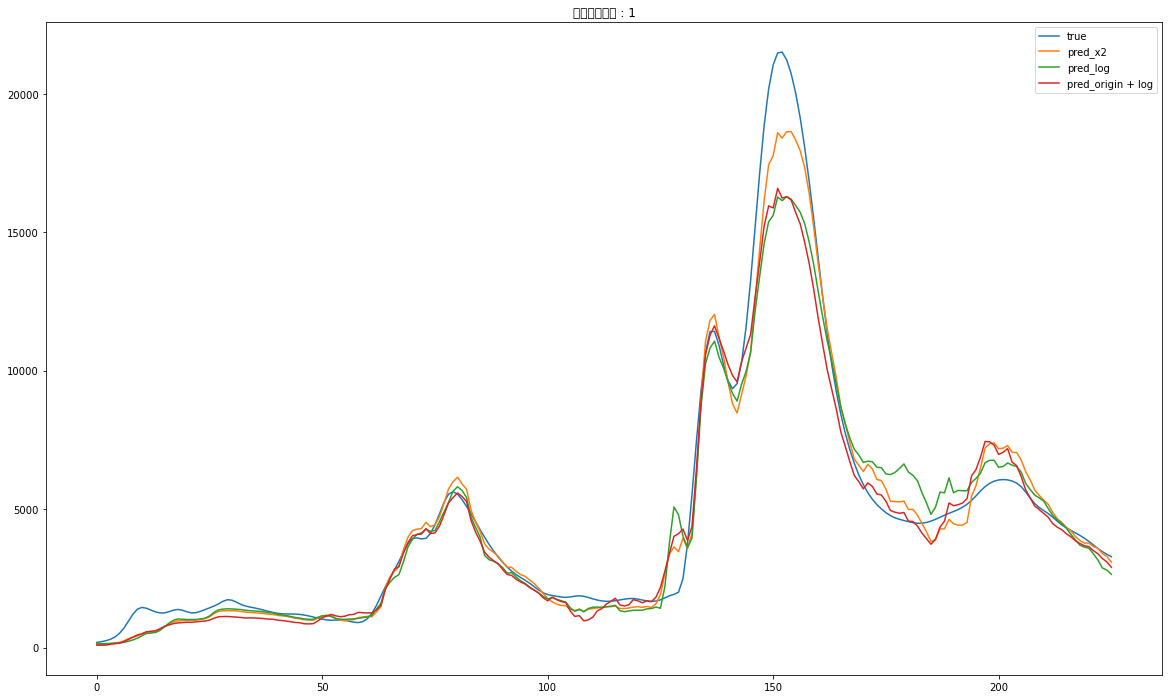

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

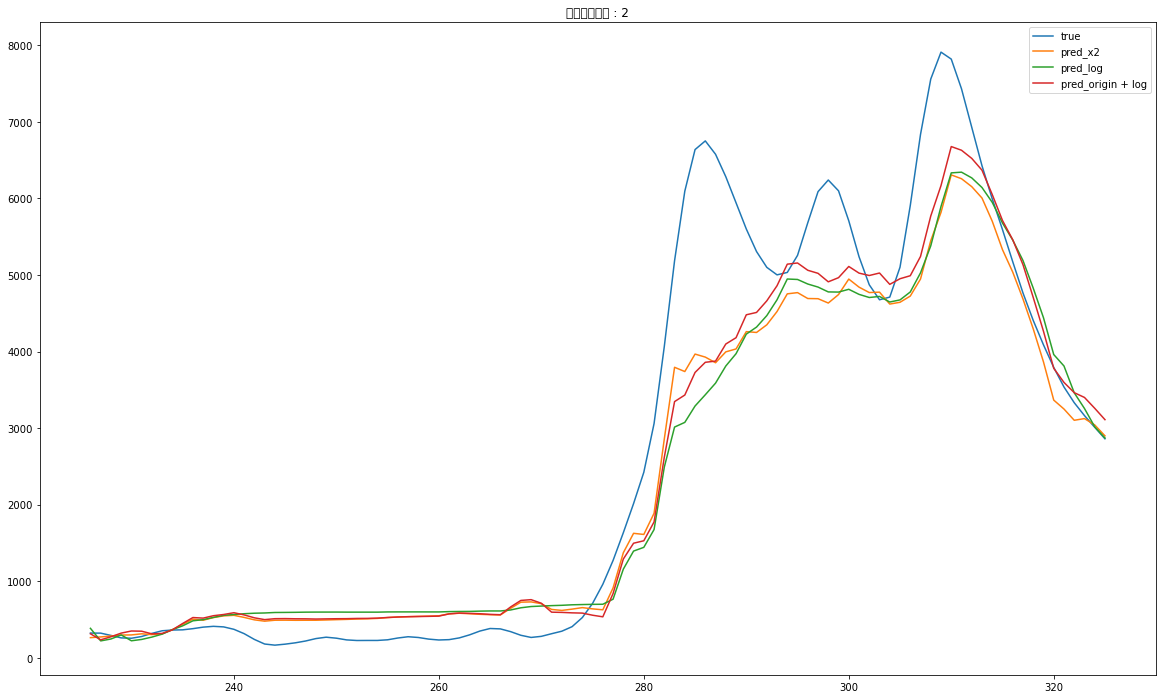

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

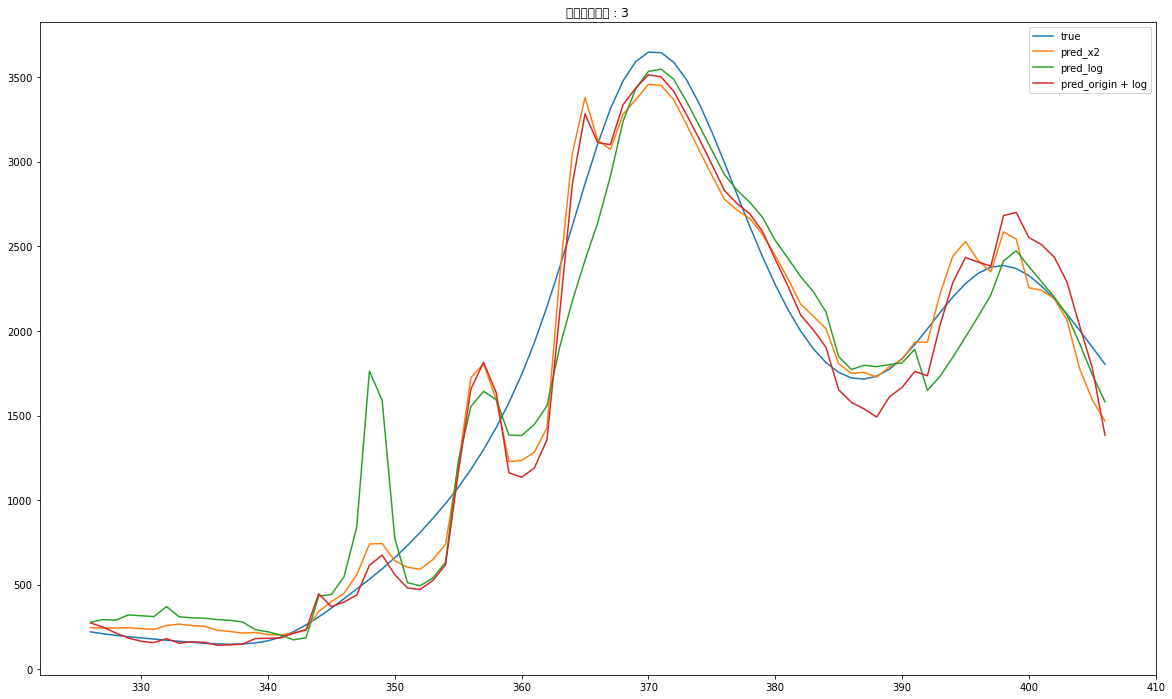

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

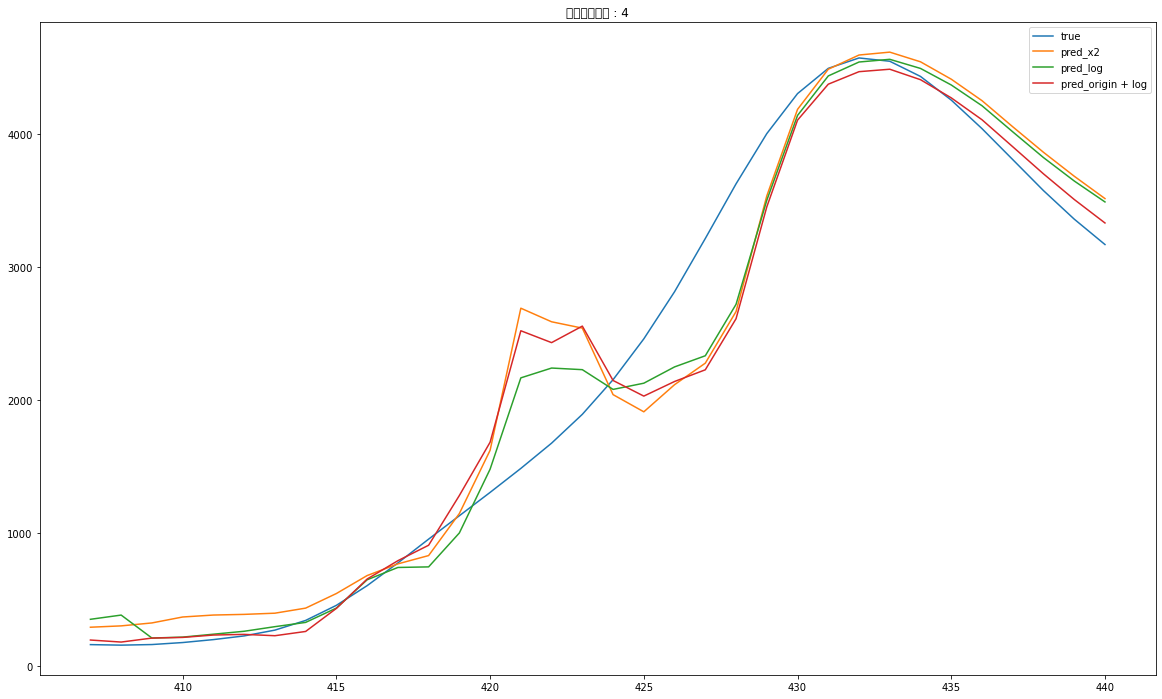

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

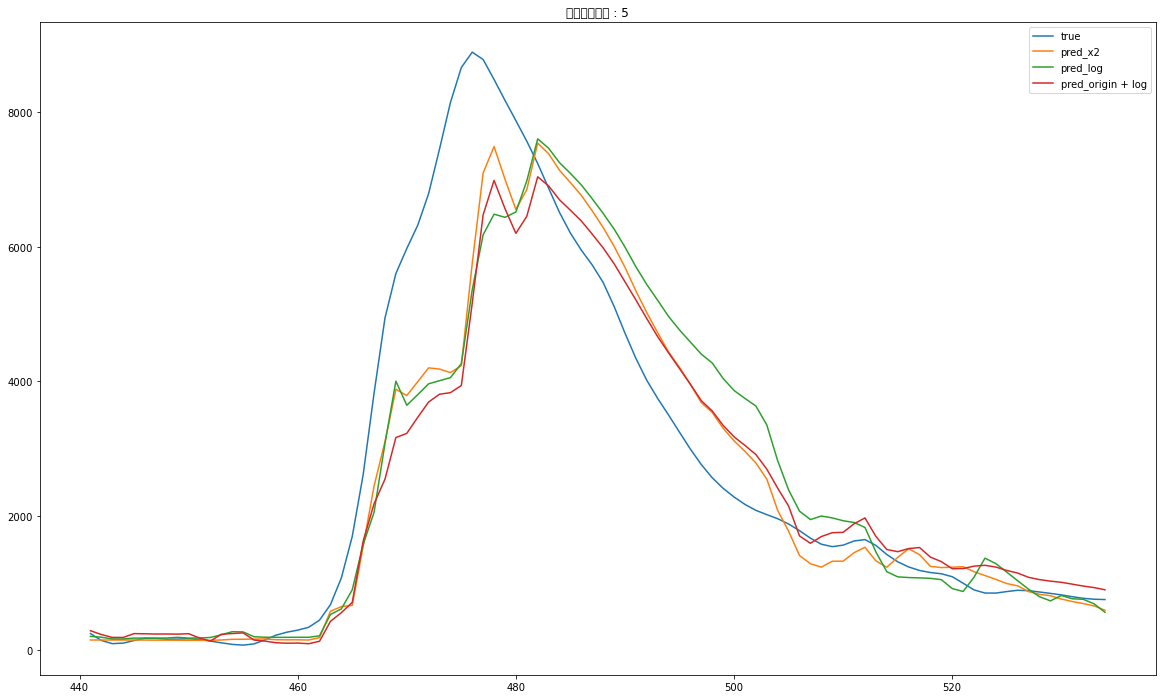

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

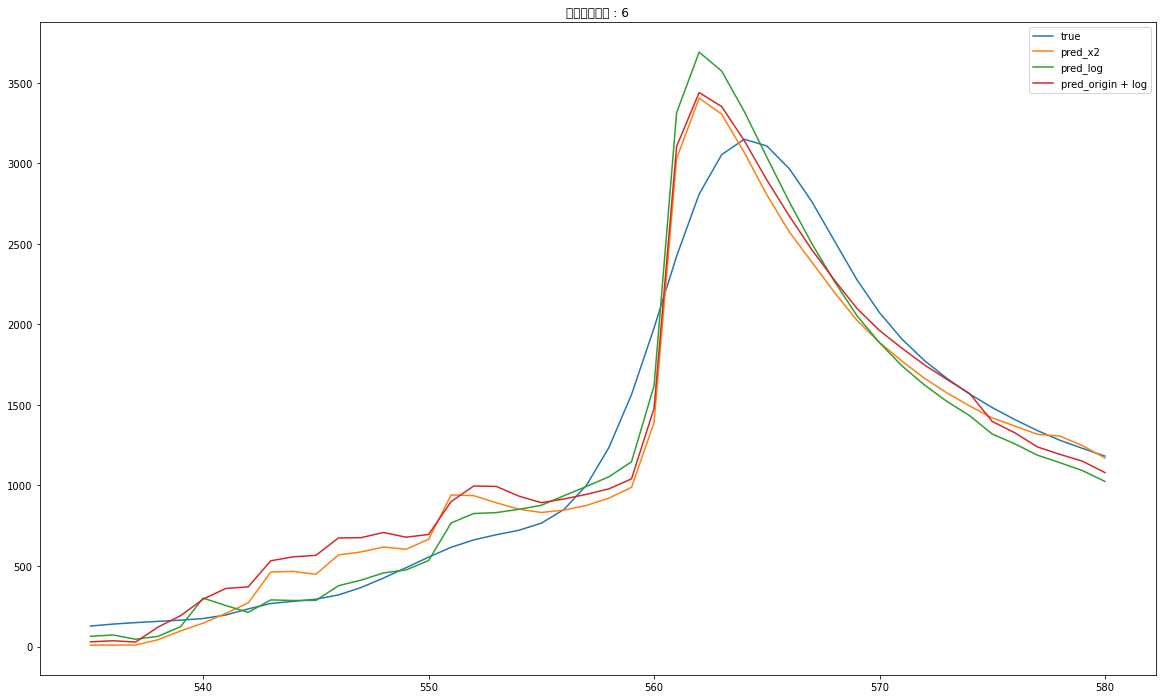

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

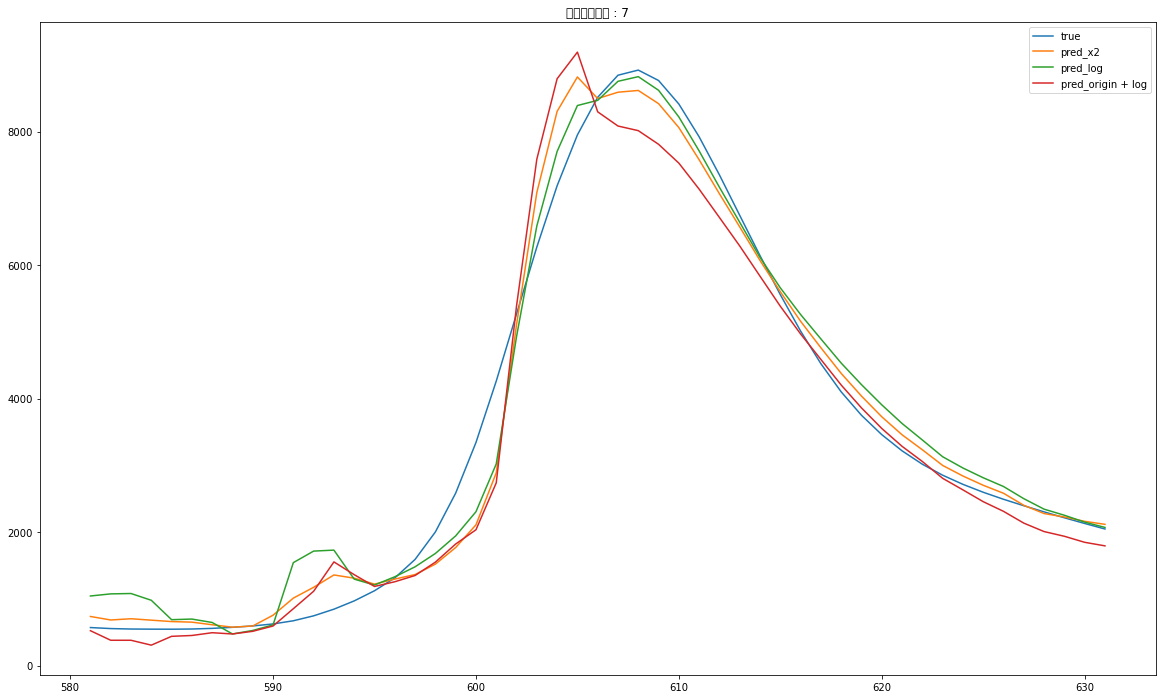

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

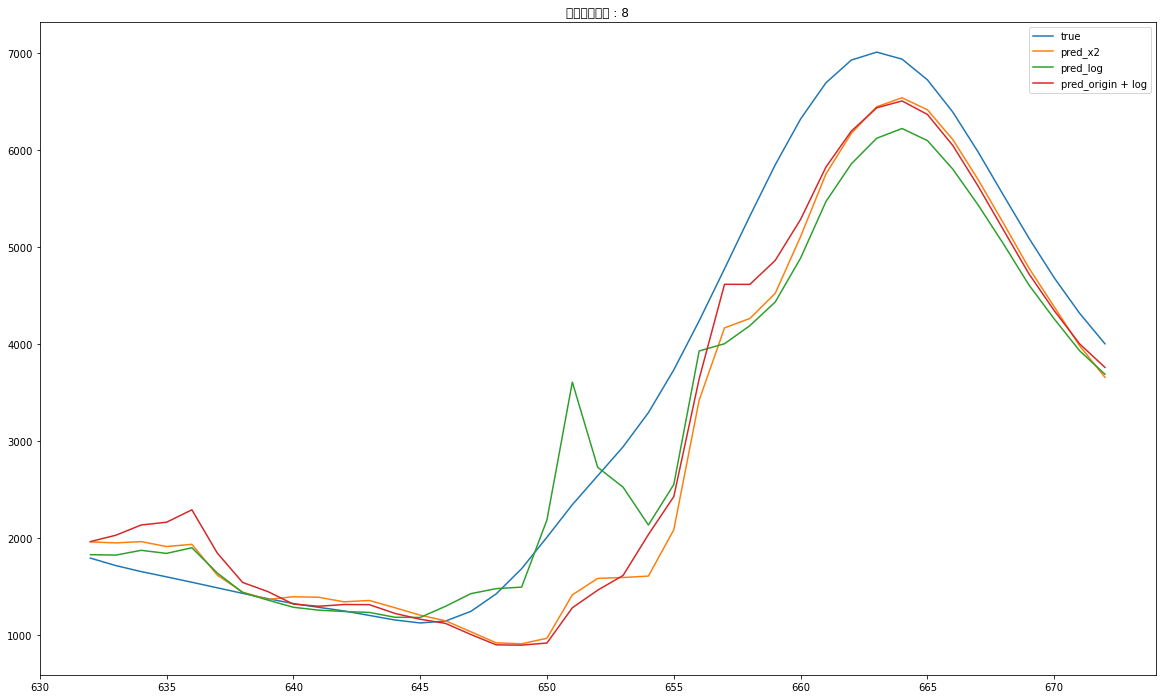

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

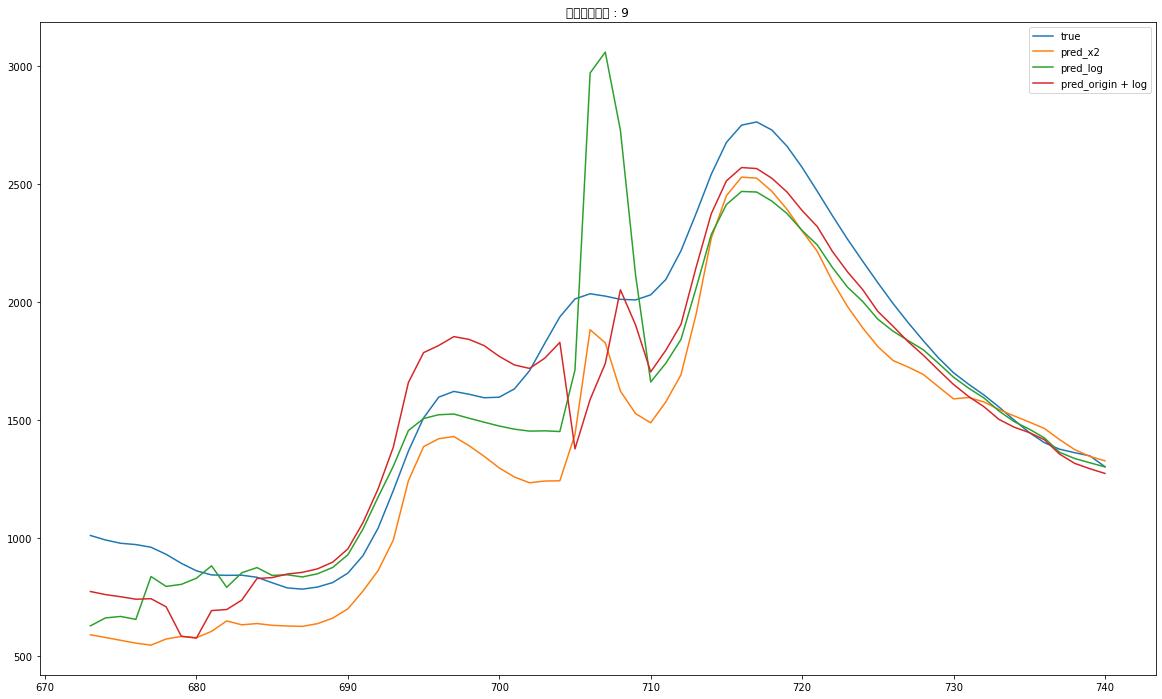

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

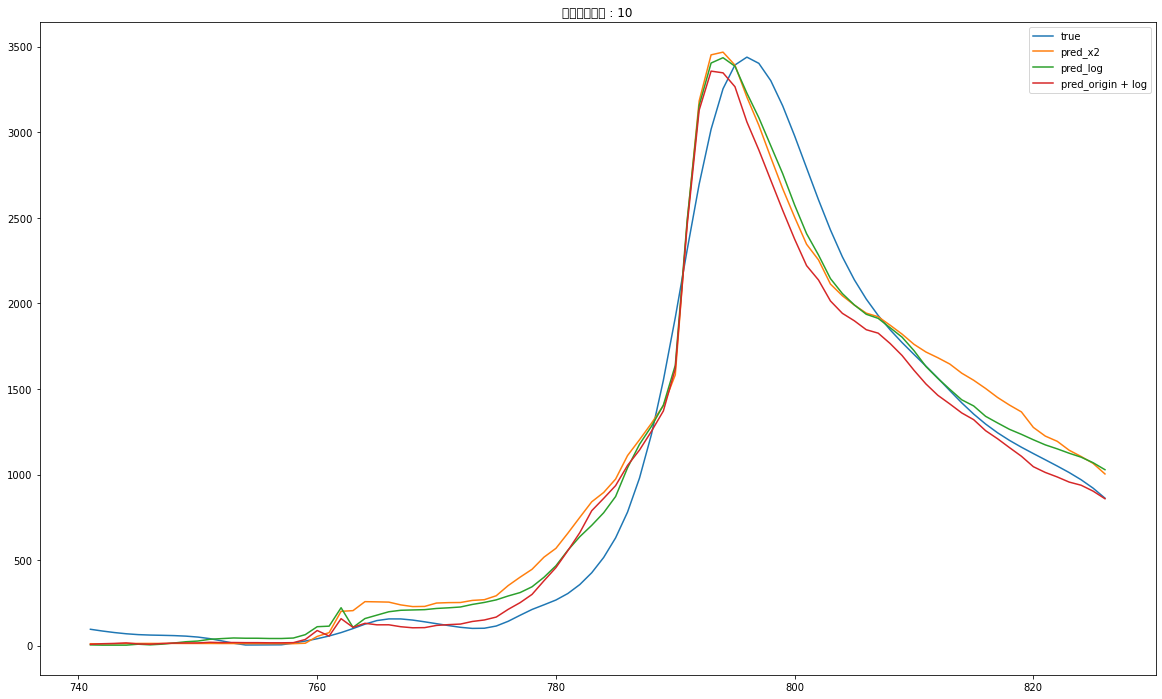

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

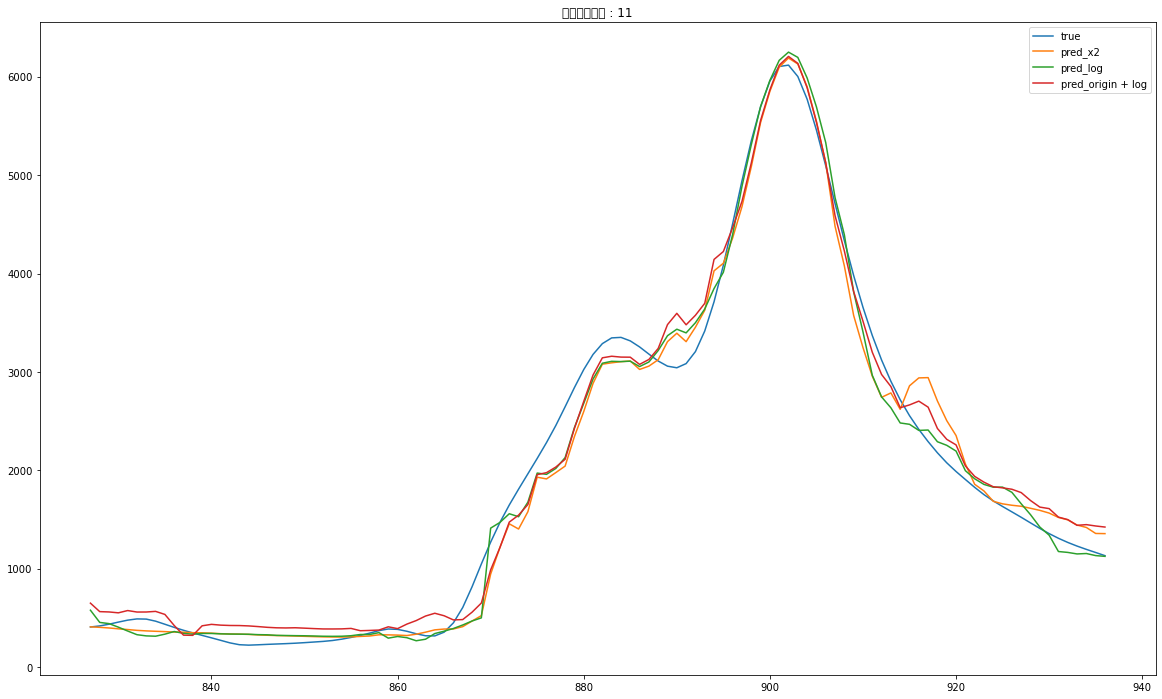

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

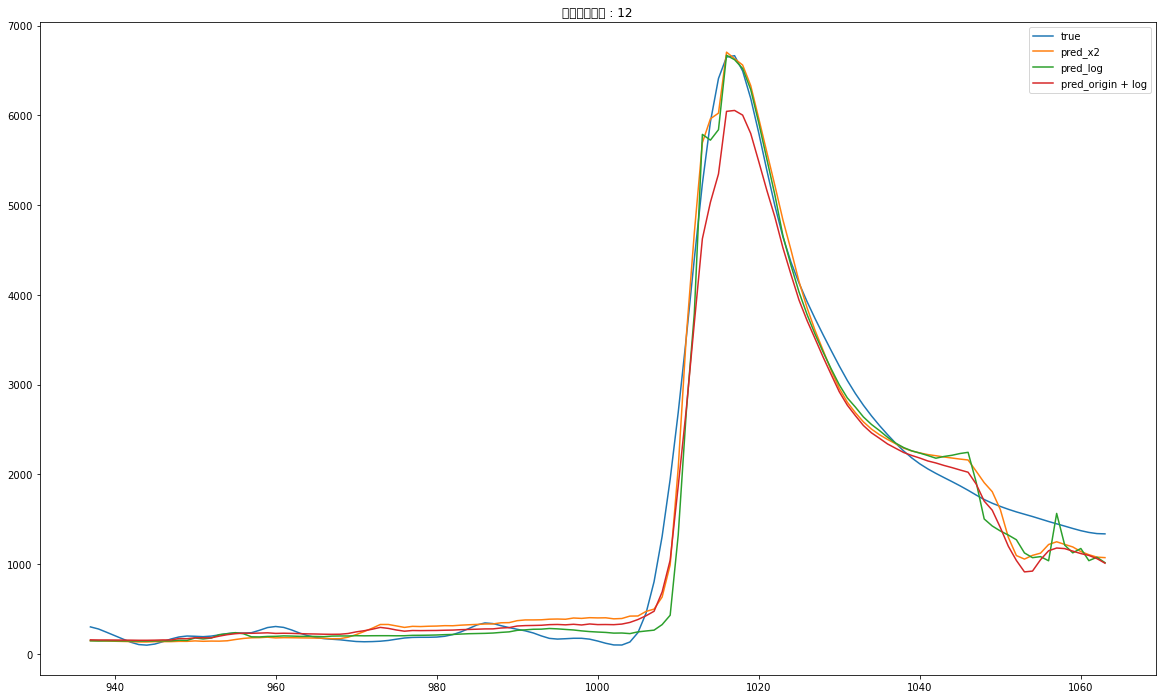

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

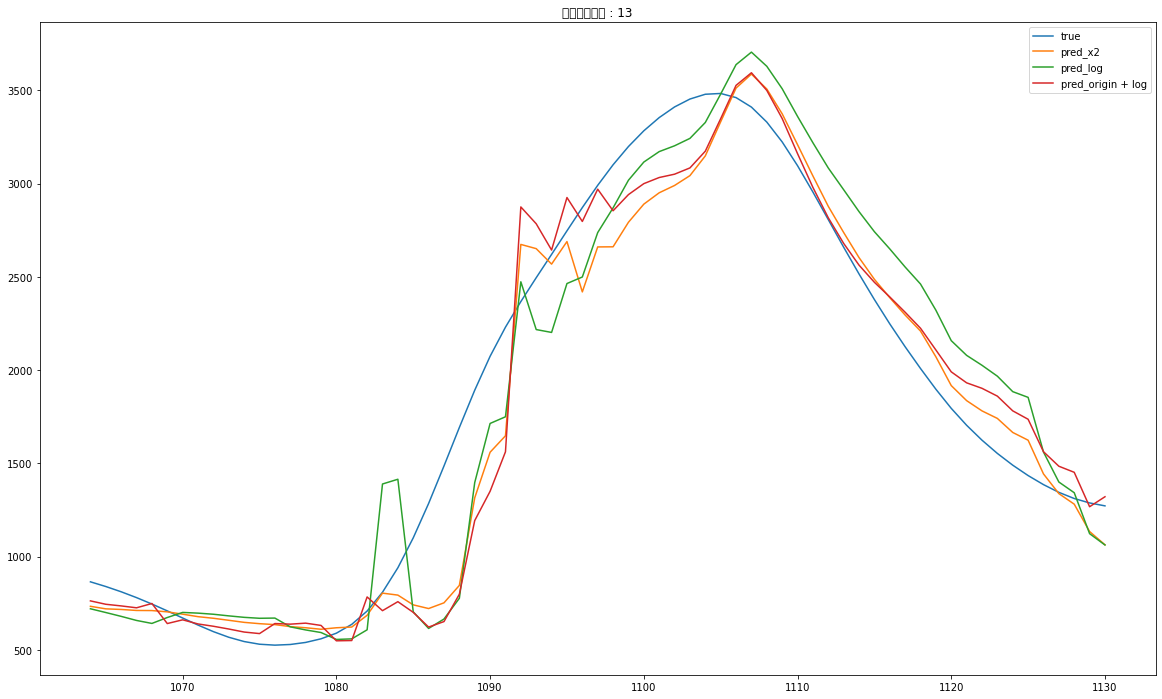

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

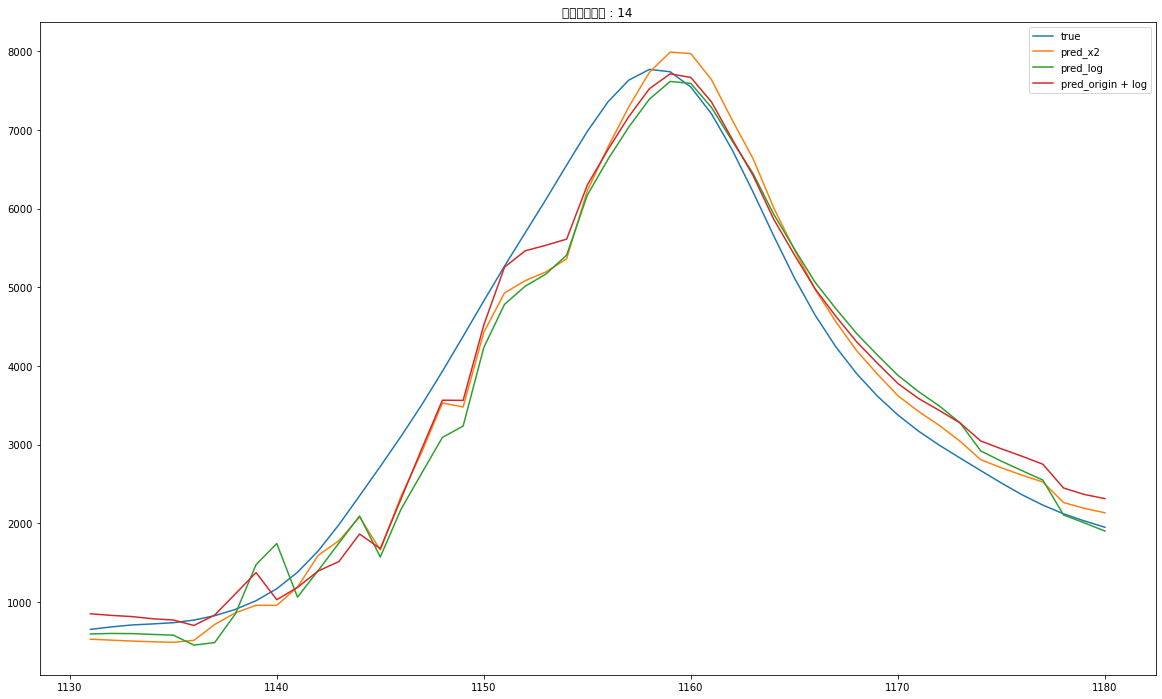

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

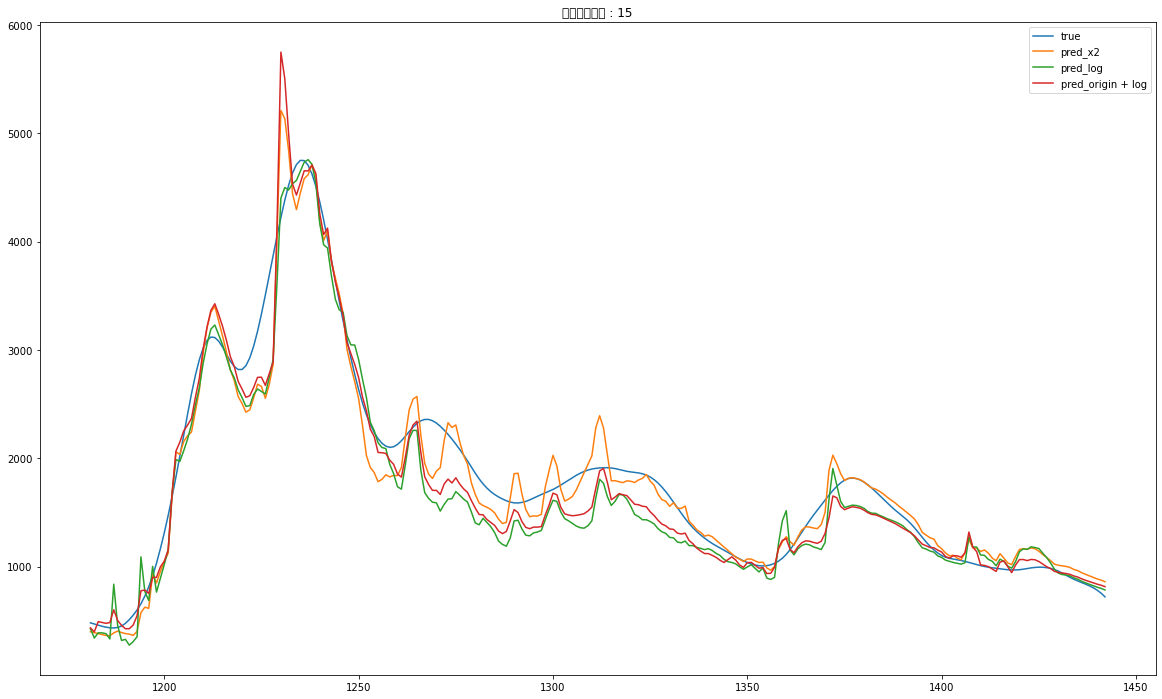

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

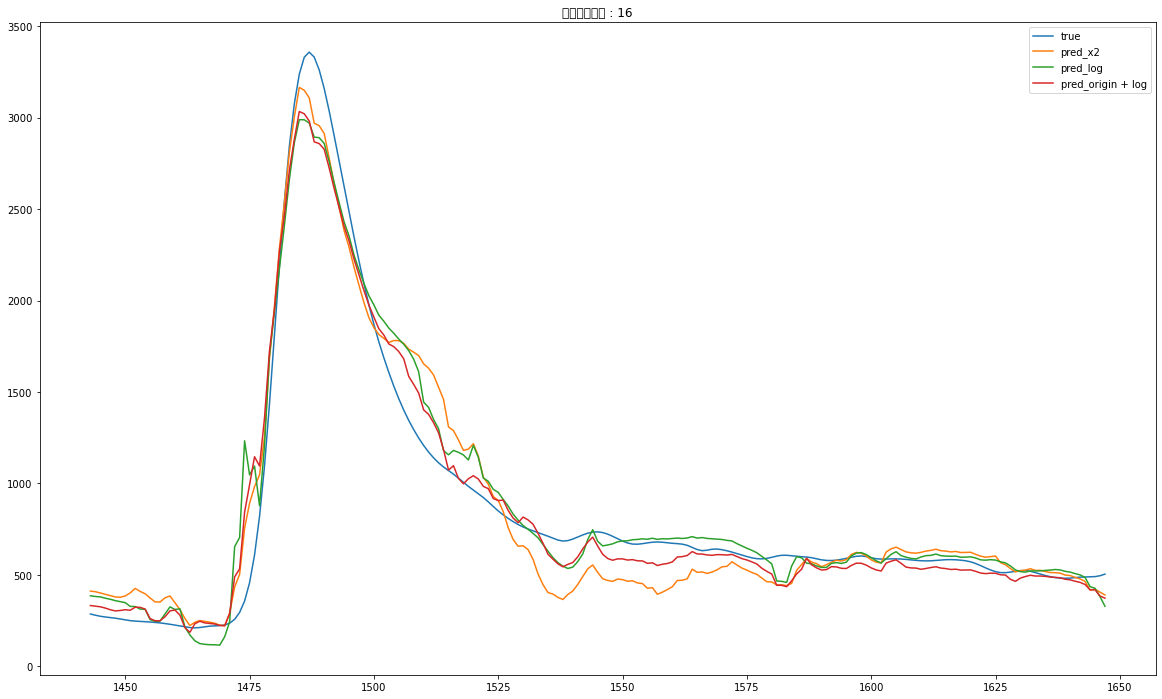

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

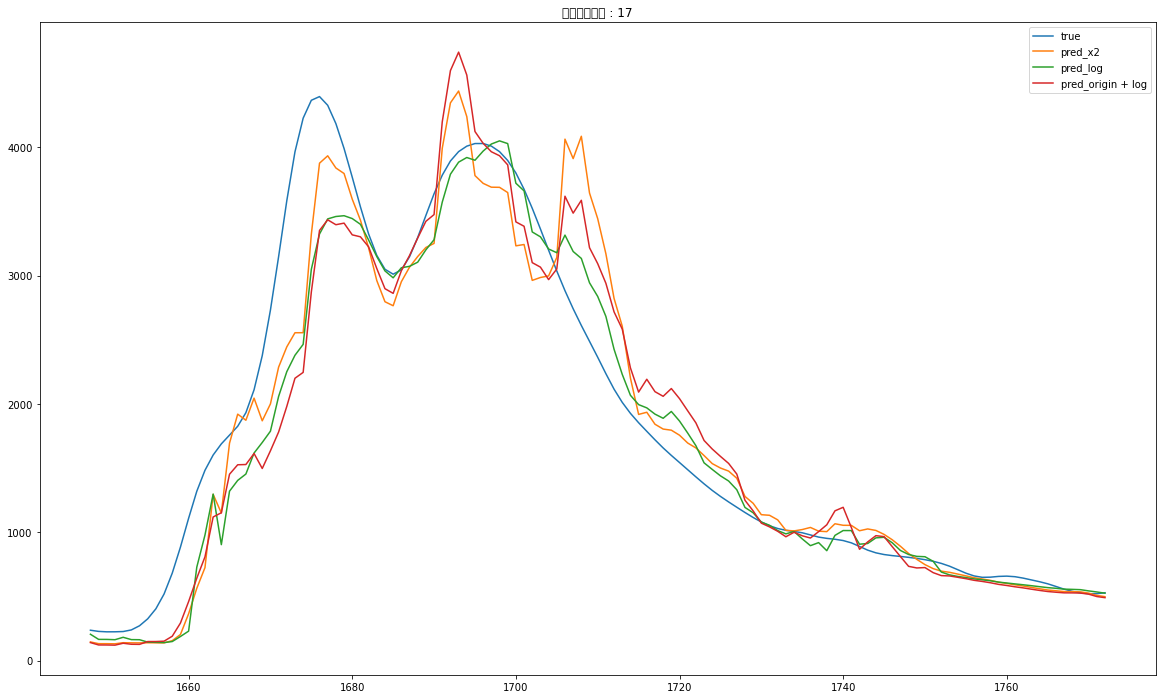

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

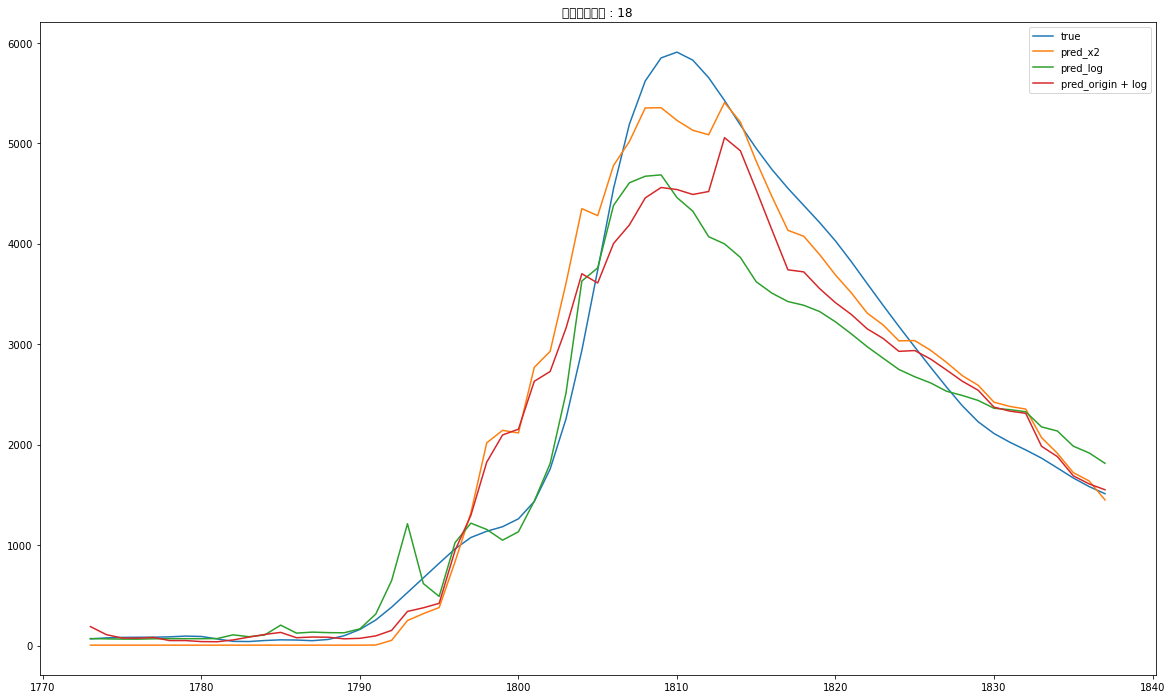

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

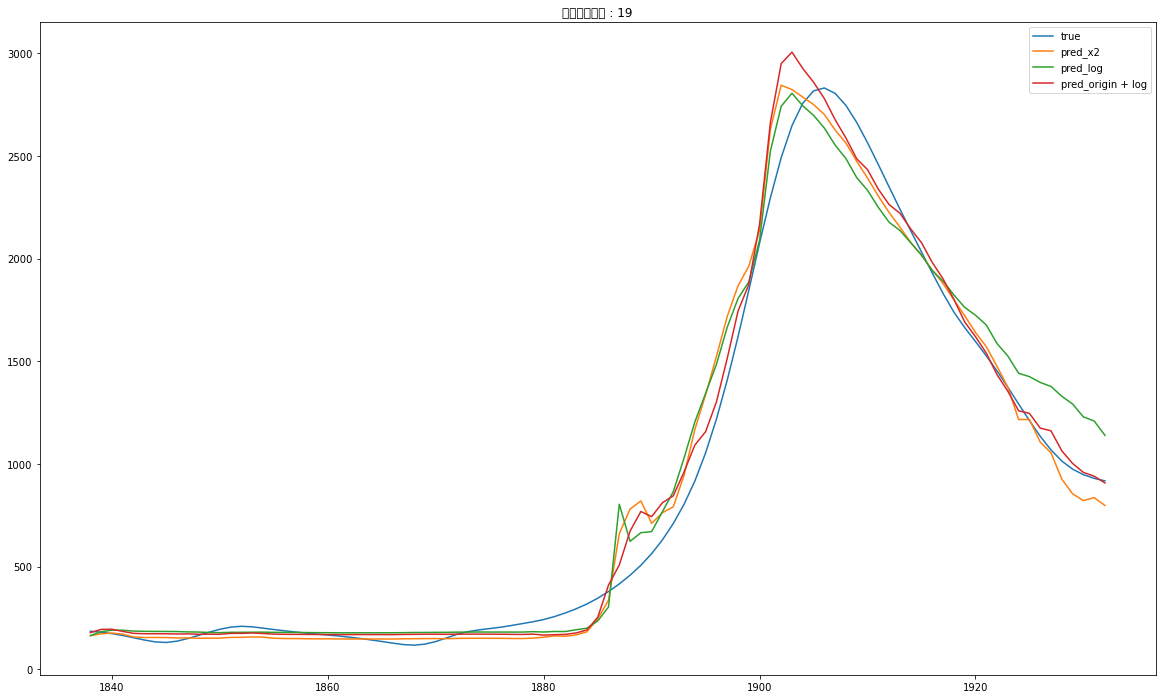

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

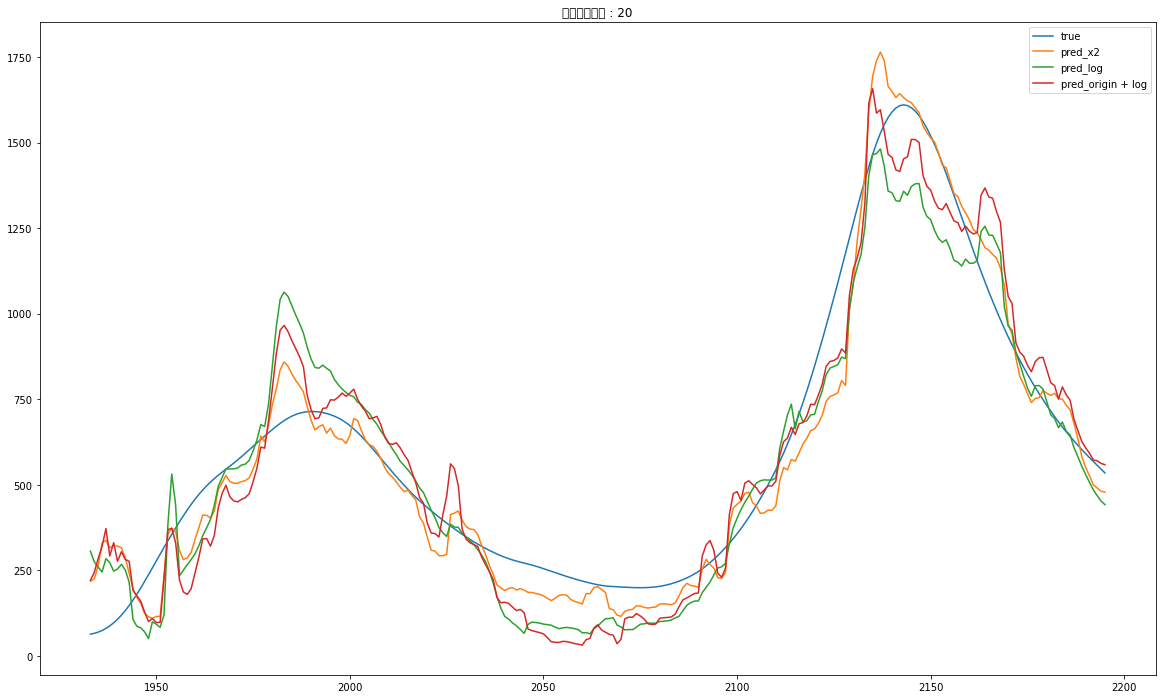

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

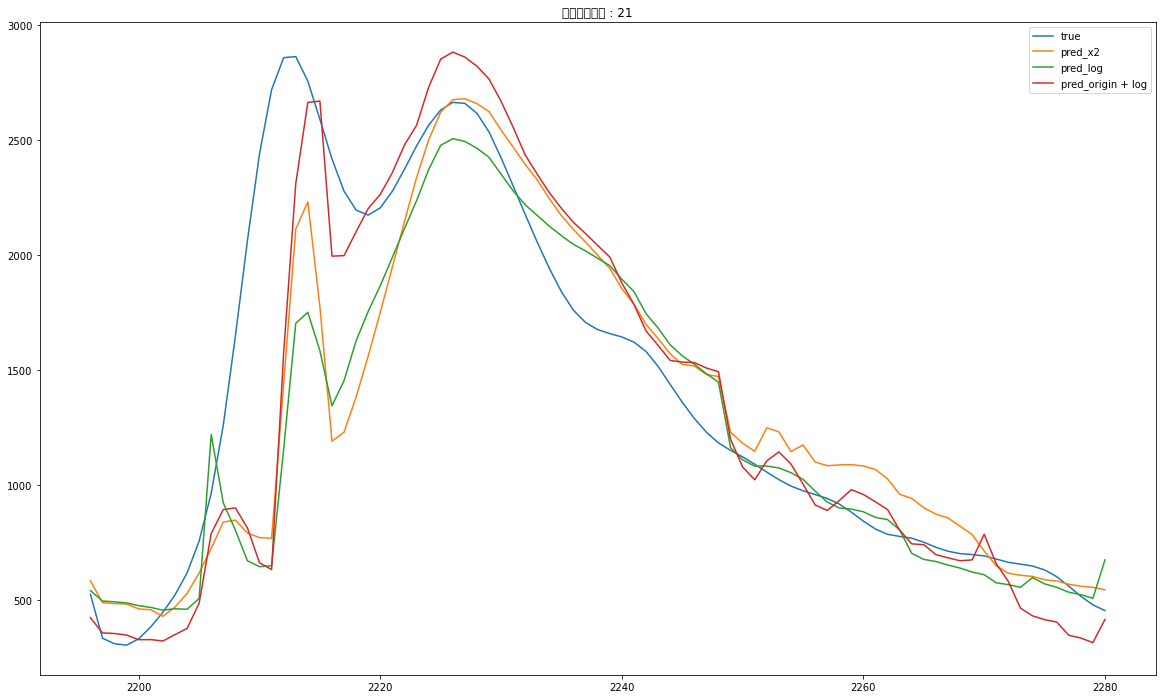

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

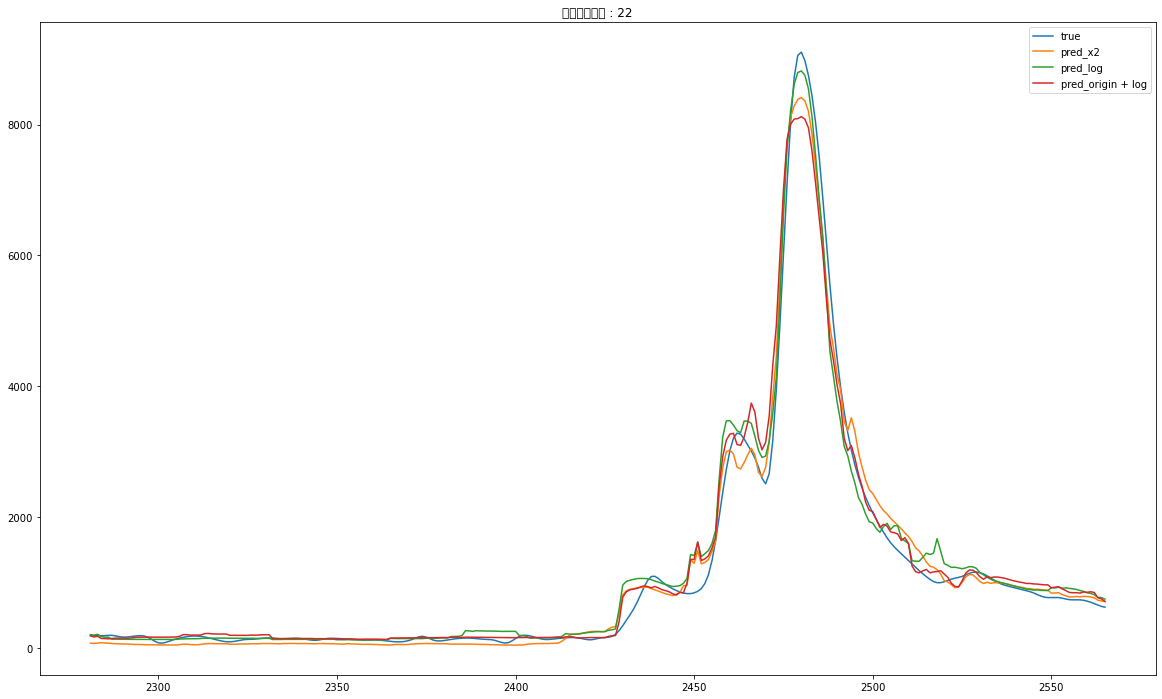

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

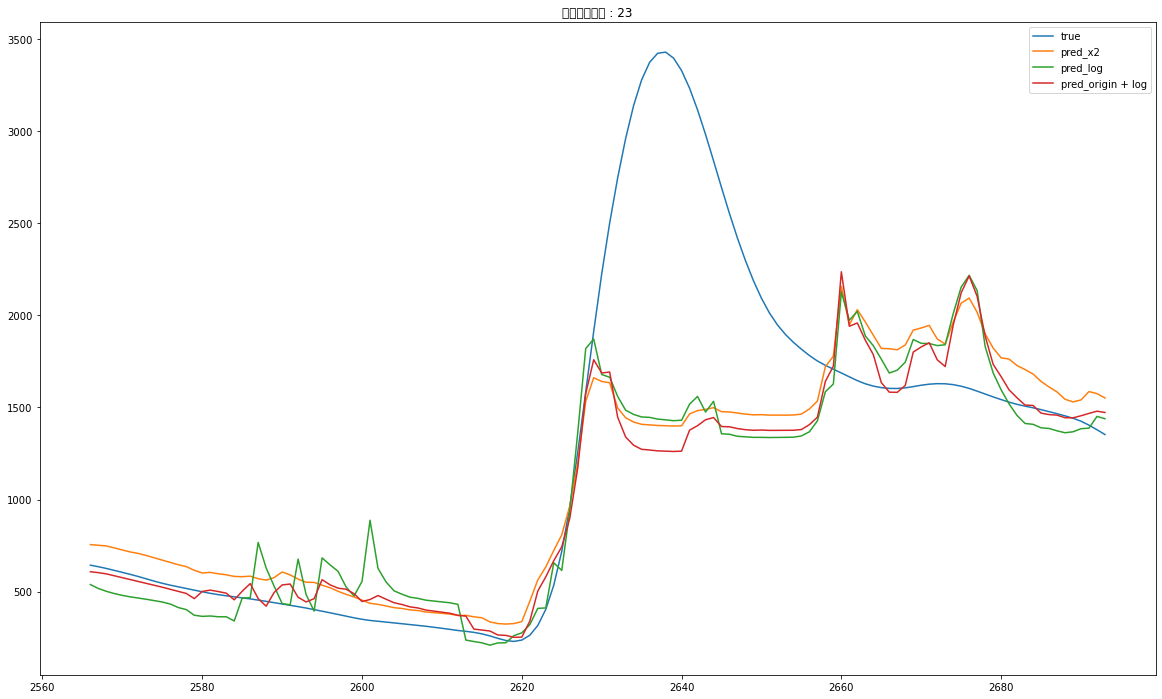

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

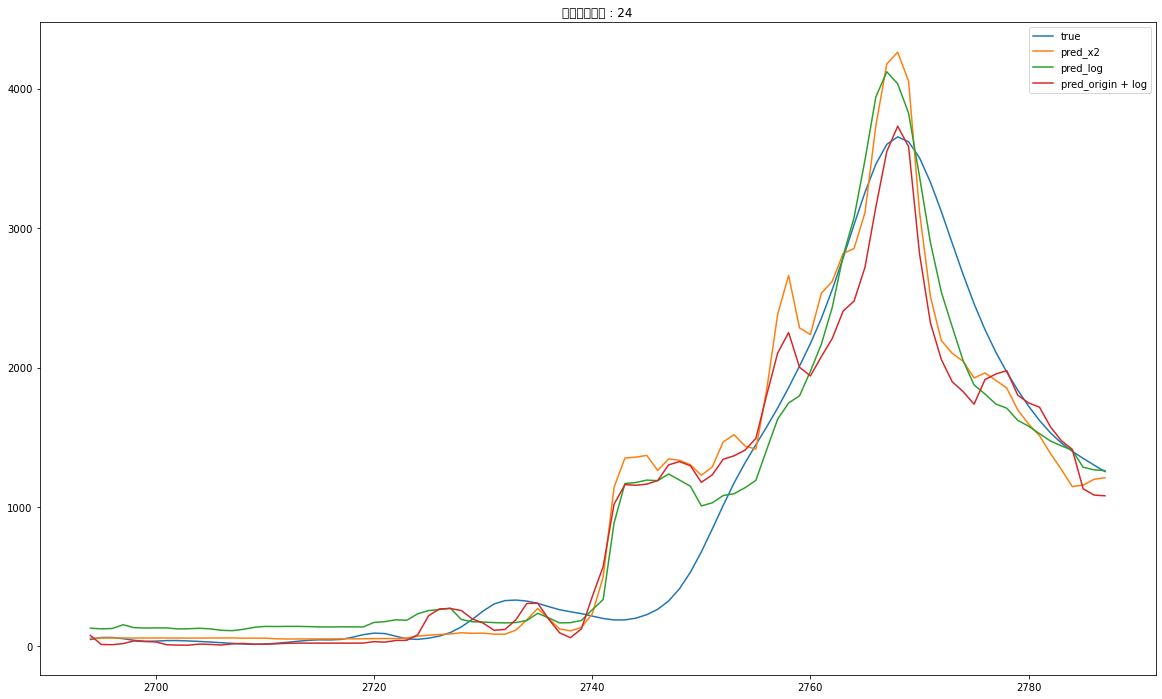

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54840 missing from c

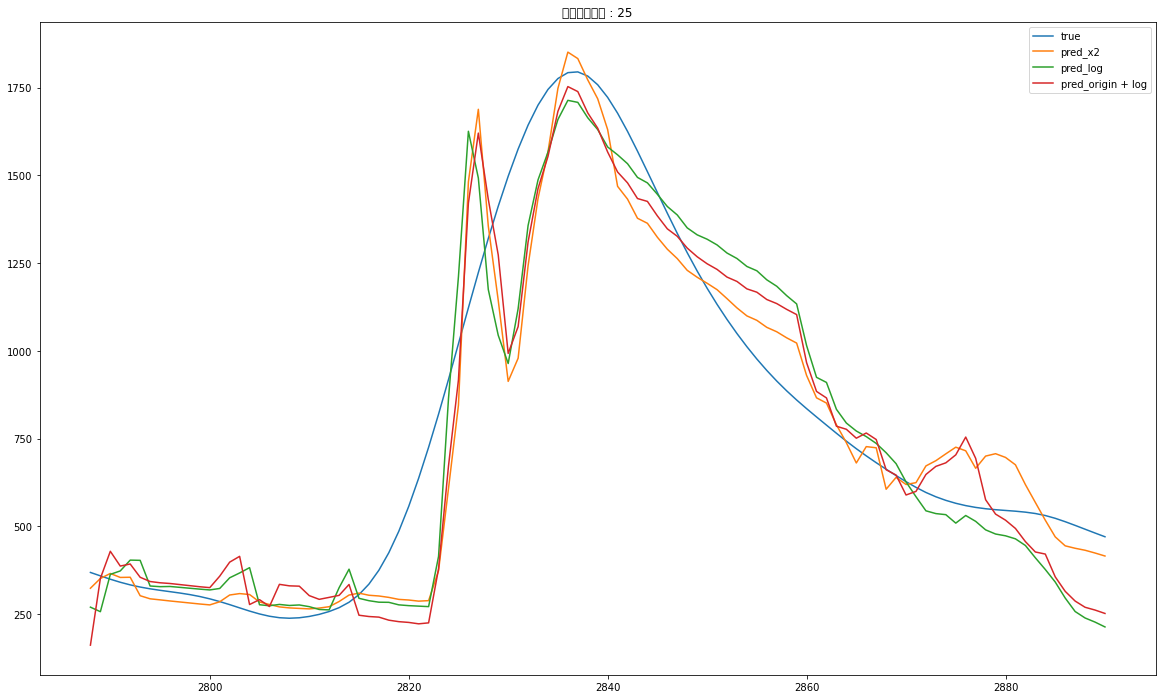

In [54]:
plot_hongsunum(predict_df)